# Machine Learning in Particle Physics (Supervised Learning) — Exercise

In this notebook, you will apply the knowledge gained from the supervised learning hands-on session (see `iSTEP_SupervisedLearning_HandsOn.ipynb`) to complete the following exercise.

## Exercise overview

For this exercise, we will use a toy example rooted in physics: searching for heavier vector bosons at the LHC, specifically the Z' (Z-prime). When Z' decays into a quark-antiquark pair, it produces dijet events. However, this signal can easily be confused with the multijet background from QCD processes, which can also generate dijet events through mechanisms such as gluon splitting into two quarks or one quark and one gluon. This example will utilize the $Z' \to qq$ signal and the QCD multijet background as the context for exploring how to train more effective machine learning models in a supervised learning scenario.

As a preview, this exercise has two branches, and your team can choose one as the focus for your research. Here is an overview of each:

- **A. Physics strategy for using AI:** Investigate how to construct physics variables that can enhance classification performance. How do models trained on samples from specific Z' mass points perform when tested on samples from other Z' mass points?

- **B. AI engineering:** Explore how optimizing neural network design and training (such as adding more layers to the DNN, switching to transformer networks as a backbone, and tuning the learning rate and training epochs) can improve classification performance.

### About the presentation

In Saturday's presentation, you can consider following this structure to introduce your research:

- Briefly explain the physics motivation behind Z' physics (you may refer to this theoretical review: [arXiv:0801.1345](https://arxiv.org/abs/0801.1345)).
- Introduce the dataset and display the distributions of some relevant variables.
- Focus on A/B to deliver your research (the programs for generating these basic plots are available in the hands-on notebook and this notebook, but feel free to include additional plots based on your insights!)
- Present your research conclusions.

Finally, remember to establish reasonable team divisions and effectively utilize AI tools (for understanding literature, comprehending code, modifying or writing code, etc).

Let's get started!


## Analyzing the Z' dataset

The provided example of $Z' \to qq$ includes four Z' mass points: 1, 1.5, 2, and 2.5 TeV. Each mass point is stored in one root file, with each file containing 50,000 events. The QCD multijet process is stored in one file, containing 100,000 events.

In [1]:
import numpy as np
import pandas as pd
import uproot as r
import awkward as ak
import matplotlib.pyplot as plt

In [2]:
def read_arrays(file_path):
    """
    Read arrays from a ROOT file.
    """
    import uproot as r
    f = r.open(file_path)
    tree = f["Delphes"]

    # read jet features as variable-length arrays (padded with zeros)
    jet_pt = ak.fill_none(ak.pad_none(tree["Jet.PT"].array(), 4, axis=1), 0)
    jet_eta = ak.fill_none(ak.pad_none(tree["Jet.Eta"].array(), 4, axis=1), 0)
    jet_phi = ak.fill_none(ak.pad_none(tree["Jet.Phi"].array(), 4, axis=1), 0)
    jet_mass = ak.fill_none(ak.pad_none(tree["Jet.Mass"].array(), 4, axis=1), 0)

    # build jet features as a dataframe
    df = pd.DataFrame({
        "jet_pt1": jet_pt[:, 0],
        "jet_eta1": jet_eta[:, 0],
        "jet_phi1": jet_phi[:, 0],
        "jet_mass1": jet_mass[:, 0],
        "jet_pt2": jet_pt[:, 1],
        "jet_eta2": jet_eta[:, 1],
        "jet_phi2": jet_phi[:, 1],
        "jet_mass2": jet_mass[:, 1],
        # "jet_pt3": jet_pt[:, 2],
        # "jet_eta3": jet_eta[:, 2],
        # "jet_phi3": jet_phi[:, 2],
        # 'jet_mass3': jet_mass[:, 2],
    })
    # build other jet variables
    df["jet_deta12"] = abs(df["jet_eta1"] - df["jet_eta2"])
    df['jet_dphi12'] = (df['jet_phi1'] - df['jet_phi2']) % (2 * np.pi)  # constrain to [0, 2pi]
    return df

Reminder: Copy the following files from the previous session into the `data/` directory.

In [3]:
file_list = [
    './data/delphes_zprime_1TeV.root',
    './data/delphes_zprime_1p5TeV.root',
    './data/delphes_zprime_2TeV.root',
    './data/delphes_zprime_2p5TeV.root',
    './data/delphes_multijet.root',
]

df_list = []
for i, file in enumerate(file_list):
    df_list.append(read_arrays(file))  # Read features from ROOT file and append to list
    if 'zprime_1TeV' in file:  # Assign integer label to each sample for classification
        df_list[i]['label'] = 1
    elif 'zprime_1p5TeV' in file:
        df_list[i]['label'] = 2
    elif 'zprime_2TeV' in file:
        df_list[i]['label'] = 3
    elif 'zprime_2p5TeV' in file:
        df_list[i]['label'] = 4
    elif 'multijet' in file:
        df_list[i]['label'] = 0  # background

    # a variable used as training label: (signal: 1, background: 0)
    df_list[i]['label_is_sig'] = (df_list[i]['label'] > 0).astype(int)

df = pd.concat(df_list, axis=0)  # Concatenate all DataFrames into a single DataFrame for analysis
df

,jet_pt1,jet_eta1,jet_phi1,jet_mass1,jet_pt2,jet_eta2,jet_phi2,jet_mass2,jet_deta12,jet_dphi12,label,label_is_sig
0,431.166626,-0.409789,-0.053466,16.269297,409.961182,0.653760,3.079527,16.136507,1.063549,3.150192,1,1
1,281.611206,-0.309674,0.142321,5.474829,266.998352,1.263712,-2.993311,9.688689,1.573386,3.135632,1,1
2,430.977814,0.712181,1.090687,12.586125,404.504059,-0.164918,-2.051517,12.297118,0.877099,3.142204,1,1
3,540.412903,0.508327,1.826380,17.101940,400.870605,0.364258,-1.318158,13.366835,0.144070,3.144537,1,1
4,221.092957,-0.547750,-1.200881,2.974811,215.453430,2.328024,1.938679,9.611918,2.875774,3.143626,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,113.362823,-0.791257,0.909017,5.877603,90.417923,-2.293667,-2.210016,6.940484,1.502410,3.119033,0,0
99996,156.986099,1.158455,0.568787,16.566175,111.824272,2.234097,-2.614952,7.807077,1.075643,3.183739,0,0
99997,126.222260,2.718263,-3.091912,4.411303,123.380188,0.561036,0.059249,9.470507,2.157227,3.132025,0,0
99998,108.420639,1.886348,3.070095,6.271837,92.195427,0.425001,-0.089519,9.848572,1.461346,3.159614,0,0


Referring to the hands-on notebook, we will plot the distributions of several variables.

Can we create some new variables based on these basic variables that could better distinguish between the signal and the background?

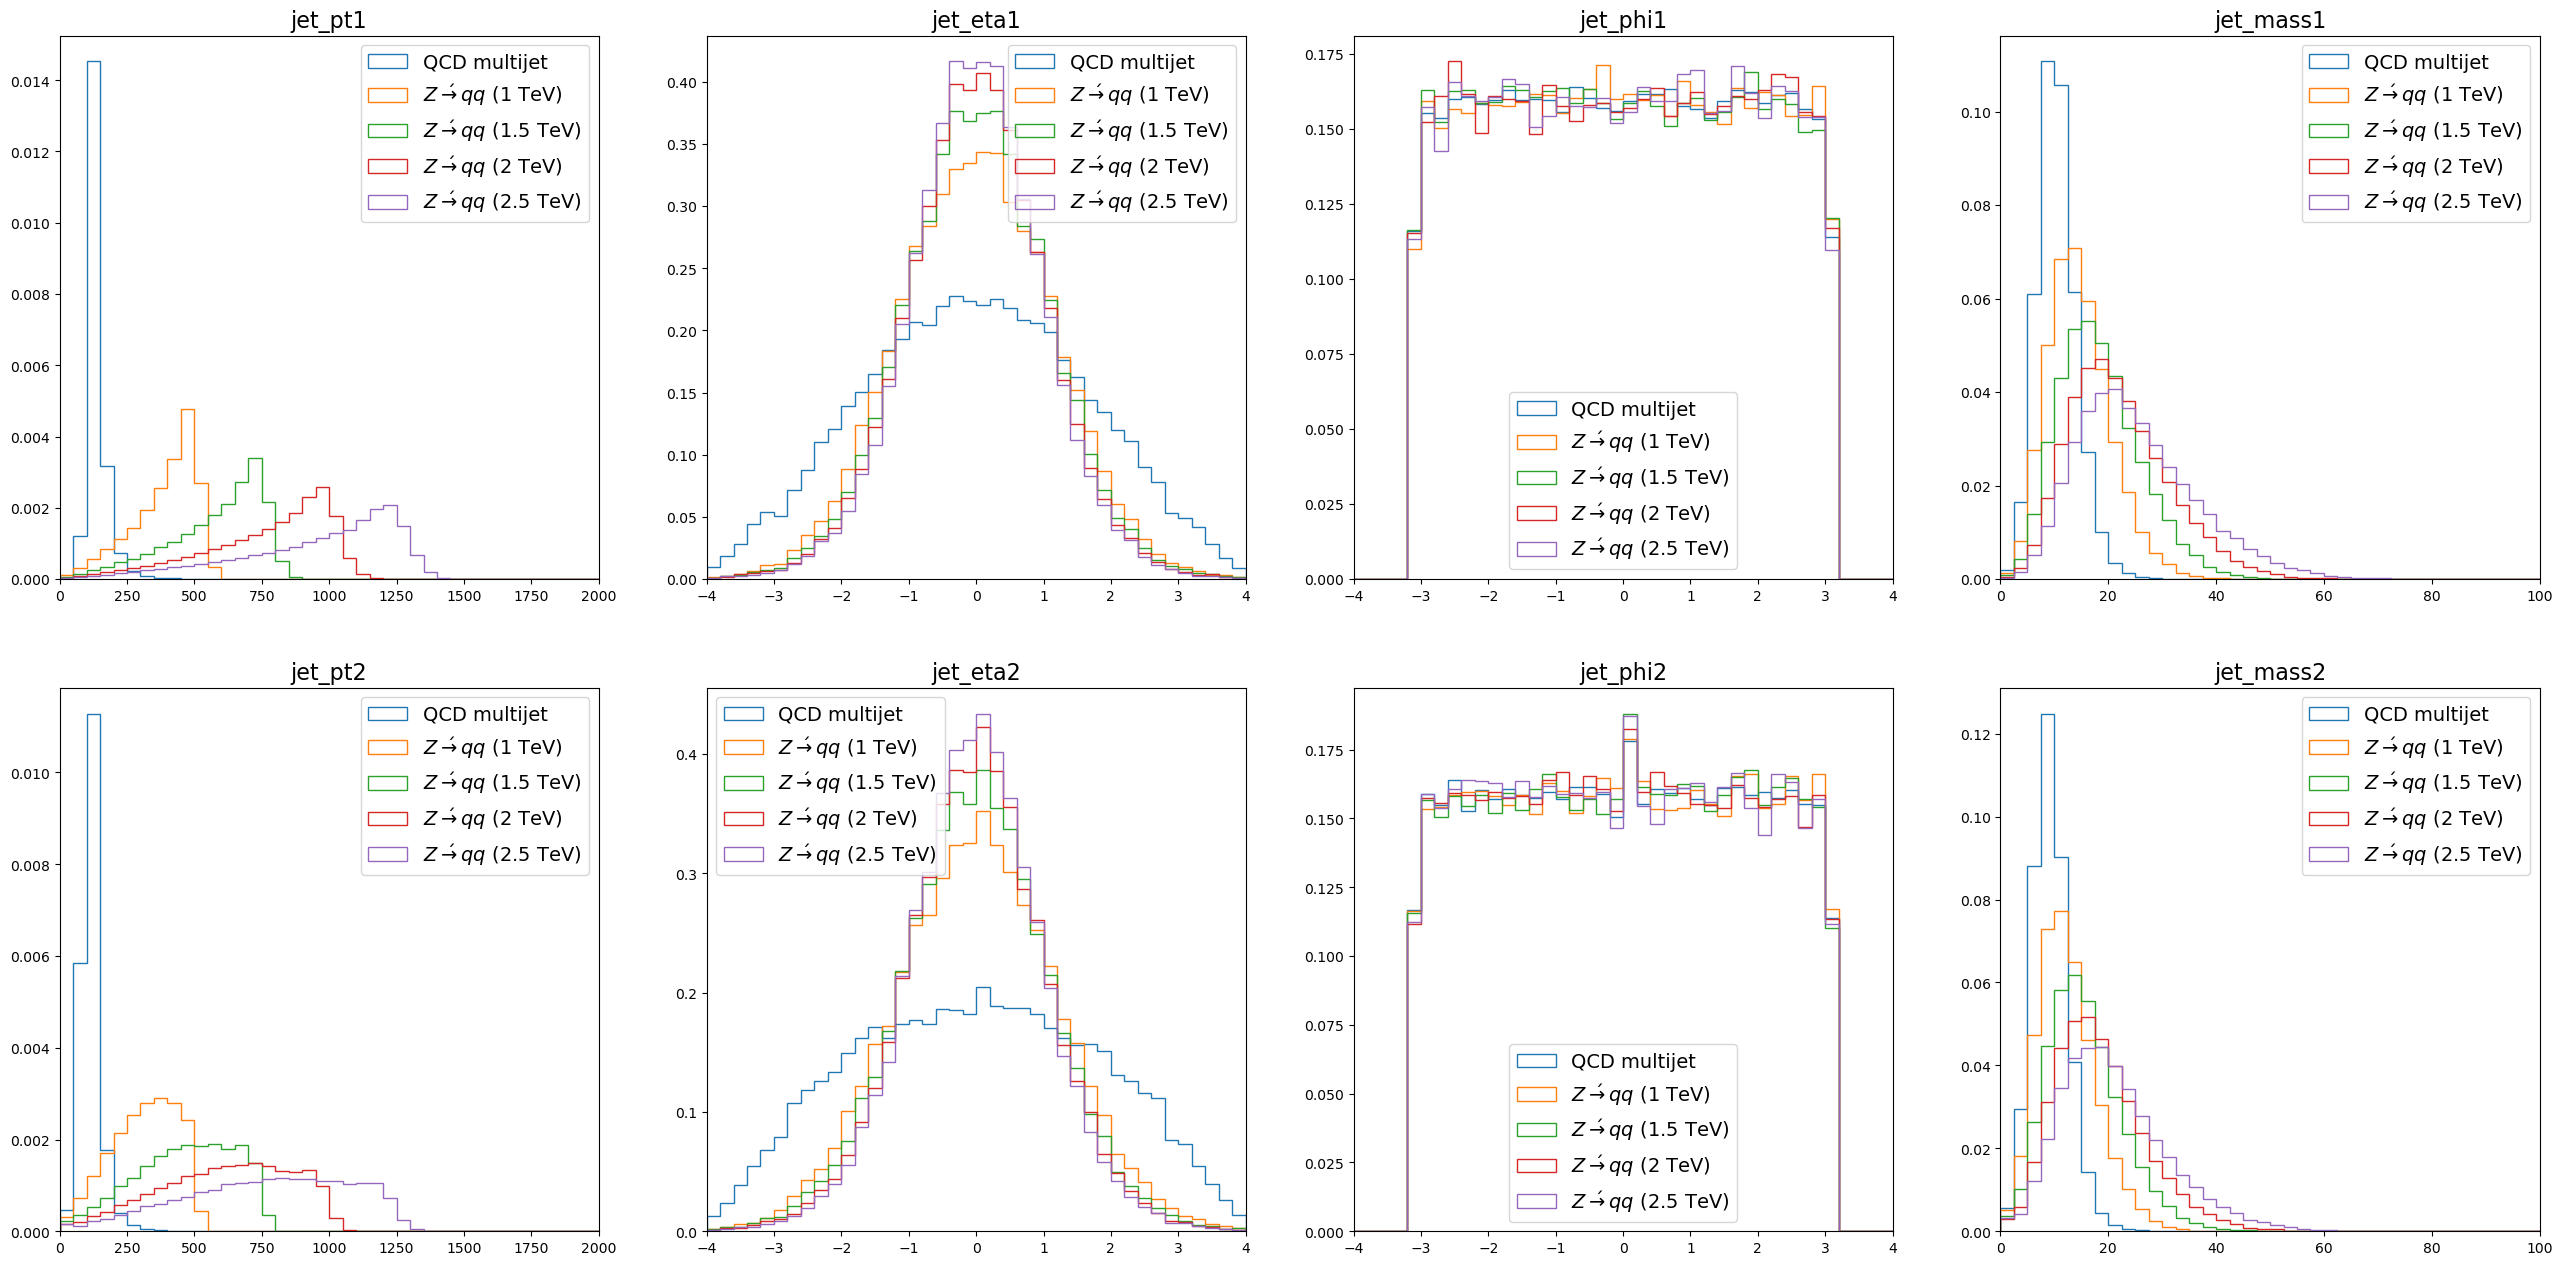

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Define a list of tuples for plotting: (variable name, number of bins, x-axis min, x-axis max)
plotinfo = [ # varname, nbin, xmin, xmax
    ('jet_pt1', 40, 0, 2000),         # Transverse momentum of the leading jet
    ('jet_eta1', 40, -4, 4),          # Pseudorapidity of the leading jet
    ('jet_phi1', 40, -4, 4),          # Azimuthal angle of the leading jet
    ('jet_mass1', 40, 0, 100),        # Mass of the leading jet
    ('jet_pt2', 40, 0, 2000),         # Transverse momentum of the subleading jet
    ('jet_eta2', 40, -4, 4),          # Pseudorapidity of the subleading jet
    ('jet_phi2', 40, -4, 4),          # Azimuthal angle of the subleading jet
    ('jet_mass2', 40, 0, 100),        # Mass of the subleading jet
]

plt.figure(figsize=(32, 24))  # Set the overall figure size for all subplots

for i, (varname, nbin, xmin, xmax) in enumerate(plotinfo):
    plt.subplot(3, 4, i+1)  # Arrange subplots in a 3x4 grid
    bins = np.linspace(xmin, xmax, nbin+1)  # Define bin edges for the histogram

    # Plot signal and background distributions for the current variable
    label_map = {
        'multijet': 'QCD multijet',
        'zprime_1TeV': r'$Z\'\rightarrow qq$ (1 TeV)',
        'zprime_1.5TeV': r'$Z\'\rightarrow qq$ (1.5 TeV)',
        'zprime_2TeV': r'$Z\'\rightarrow qq$ (2 TeV)',
        'zprime_2.5TeV': r'$Z\'\rightarrow qq$ (2.5 TeV)',
    }
    for i, proc in enumerate(label_map.keys()):
        df_proc = df[df['label'] == i]
        plt.hist(df_proc[varname], histtype="step", bins=bins, label=label_map[proc], density=True)

    plt.legend(fontsize=14)  # Add legend with specified font size
    plt.xlim(xmin, xmax)     # Set x-axis limits
    plt.title(varname, fontsize=16)  # Set subplot title as variable name

## Starting model training and your exploration

Now, let's transfer the machine learning models from the hands-on session! You can decide whether to transfer the boosted decision tree model, the basic DNN model, or the transformer model.

Remember to check the following details during the transfer process: Is the train/eval/test ratio still 8:1:1? Are the input feature names specified correctly? Is the dimension correct when defining the neural network?

After that, test the model you trained, making sure not to use any overlapping datasets from train/eval. As described in the hands-on session, use the distribution of scores to check the distinguishing ability, and monitor metrics with TensorBoard, as well as evaluate the model's performance using the final ROC curve.

*For your reference, we implement a basic DNN model training below as an example.*

In [5]:
# Standardize the data as we do in the hands-on session

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

input_columns = ['jet_pt1', 'jet_eta1', 'jet_phi1', 'jet_mass1', 'jet_pt2', 'jet_eta2', 'jet_phi2', 'jet_mass2', 'jet_deta12', 'jet_dphi12']

# Fit and transform the DataFrame
df_trans = pd.DataFrame(scaler.fit_transform(df[input_columns]), columns=[c + '_trans' for c in input_columns], index=df.index)
df = pd.concat([df, df_trans], axis=1)
df

,jet_pt1,jet_eta1,jet_phi1,jet_mass1,jet_pt2,jet_eta2,jet_phi2,jet_mass2,jet_deta12,jet_dphi12,...,jet_pt1_trans,jet_eta1_trans,jet_phi1_trans,jet_mass1_trans,jet_pt2_trans,jet_eta2_trans,jet_phi2_trans,jet_mass2_trans,jet_deta12_trans,jet_dphi12_trans
0,431.166626,-0.409789,-0.053466,16.269297,409.961182,0.653760,3.079527,16.136507,1.063549,3.150192,...,-0.175749,-0.320112,-0.030201,-0.066892,0.037473,0.478780,1.703005,0.222721,-0.352337,0.067607
1,281.611206,-0.309674,0.142321,5.474829,266.998352,1.263712,-2.993311,9.688689,1.573386,3.135632,...,-0.598563,-0.241924,0.077850,-1.240281,-0.433486,0.924799,-1.654371,-0.578385,0.086021,-0.031409
2,430.977814,0.712181,1.090687,12.586125,404.504059,-0.164918,-2.051517,12.297118,0.877099,3.142204,...,-0.176283,0.556120,0.601238,-0.467263,0.019496,-0.119867,-1.133698,-0.254302,-0.512647,0.013280
3,540.412903,0.508327,1.826380,17.101940,400.870605,0.364258,-1.318158,13.366835,0.144070,3.144537,...,0.133106,0.396915,1.007254,0.023618,0.007527,0.267085,-0.728260,-0.121395,-1.142906,0.029149
4,221.092957,-0.547750,-1.200881,2.974811,215.453430,2.328024,1.938679,9.611918,2.875774,3.143626,...,-0.769657,-0.427856,-0.663440,-1.512040,-0.603289,1.703063,1.072286,-0.587923,1.205816,0.022951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,113.362823,-0.791257,0.909017,5.877603,90.417923,-2.293667,-2.210016,6.940484,1.502410,3.119033,...,-1.074225,-0.618029,0.500977,-1.196499,-1.015190,-1.676487,-1.221325,-0.919835,0.024997,-0.144289
99996,156.986099,1.158455,0.568787,16.566175,111.824272,2.234097,-2.614952,7.807077,1.075643,3.183739,...,-0.950896,0.904649,0.313210,-0.034621,-0.944672,1.634380,-1.445195,-0.812165,-0.341939,0.295741
99997,126.222260,2.718263,-3.091912,4.411303,123.380188,0.561036,0.059249,9.470507,2.157227,3.132025,...,-1.037870,2.122822,-1.707068,-1.355890,-0.906603,0.410977,0.033241,-0.605493,0.588008,-0.055941
99998,108.420639,1.886348,3.070095,6.271837,92.195427,0.425001,-0.089519,9.848572,1.461346,3.159614,...,-1.088197,1.473116,1.693639,-1.153644,-1.009335,0.311503,-0.049006,-0.558521,-0.010310,0.131676


In [11]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import lightning as L
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch import nn
import torchmetrics

# Define the PyTorch Lightning model for a simple multilayer perceptron (MLP)
class SimpleMLP(L.LightningModule):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)   # First fully connected layer
        self.layer2 = nn.Linear(hidden_size, hidden_size)  # Second fully connected layer
        self.layer3 = nn.Linear(hidden_size, output_size)  # Output layer

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=output_size)  # Accuracy metrics for training
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=output_size)    # Accuracy metrics for validation

    def forward(self, x):
        # Forward pass: input -> relu -> hidden -> relu -> output
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

    def training_step(self, batch, batch_idx):
        # Defines the operations for each training batch
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.train_acc(logits, y)
        # Log training loss and accuracy
        self.log('train_loss', loss)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True)
        # Log current learning rate
        self.log('lr', self.trainer.optimizers[0].param_groups[0]['lr'])
        return loss

    def validation_step(self, batch, batch_idx):
        # Defines the operations for each validation batch
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.val_acc(logits, y)
        # Log validation loss and accuracy
        self.log('val_loss', loss)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        # Set up optimizer and learning rate scheduler
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        
        # Learning rate schedule: constant for 70% of epochs, then exponential decay to 1% of initial value
        '''
        老版本余弦退火
        def lr_lambda(epoch):
            if epoch < 0.7 * self.trainer.max_epochs:
                return 1.0
            else:
                decay_factor = (epoch - 0.7 * self.trainer.max_epochs) / (0.3 * self.trainer.max_epochs)
                return 0.01 ** decay_factor
        '''
        '''
        新版本余弦退火
        '''
        def lr_lambda(epoch):
            # 定义学习率调整函数，根据训练周期调整学习率
            # 参数 epoch: 当前训练周期
            # 返回值: 学习率调整因子
            # 如果当前周期小于总周期的70%，则保持学习率不变
            if epoch < 0.7 * self.trainer.max_epochs:
                return 1.0
            else:
                # 当周期超过70%时，使用余弦退火函数调整学习率
                # 计算衰减因子，从0到1之间变化
                decay_factor = (cos((epoch - 0.7 * self.trainer.max_epochs) / (0.3 * self.trainer.max_epochs) * pi) + 1) / 2
                # 返回0.01的decay_factor次方，实现学习率的平滑衰减
                return 0.01 ** decay_factor

        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
        return [optimizer], [scheduler]


# Define a custom PyTorch Dataset to wrap a pandas DataFrame
# See: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class DataFrameDataset(Dataset):
    def __init__(self, dataframe, input_columns, target_column):
        # Store the dataframe and extract input features and targets
        self.dataframe = dataframe
        self.inputs = dataframe[input_columns].values
        self.targets = dataframe[target_column].values

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Retrieve the input features and label for a given index
        x = torch.tensor(self.inputs[idx], dtype=torch.float32)  # N-dimensional input features
        y = torch.tensor(self.targets[idx], dtype=torch.long)    # 1-dimensional label
        return x, y

In [7]:
# These are all the input features we are using. Remember to modify them in your own research.
input_columns = ['jet_pt1', 'jet_eta1', 'jet_phi1', 'jet_mass1', 'jet_pt2', 'jet_eta2', 'jet_phi2', 'jet_mass2', 'jet_deta12', 'jet_dphi12']
target_column = 'label_is_sig'


# Split the data into training/validation/testing datasets following 80/10/10%
train_df, test_df = train_test_split(df, test_size=0.2)
val_df, test_df = train_test_split(test_df, test_size=0.5)

# Create datasets (remember to use the transformed features!)
train_dataset = DataFrameDataset(train_df, [c + '_trans' for c in input_columns], target_column)
val_dataset = DataFrameDataset(val_df, [c + '_trans' for c in input_columns], target_column)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024)

# Create Model instance (reminder: input_size is the number of features)
model_mlp = SimpleMLP(input_size=10, hidden_size=64, output_size=2)

In [12]:
# Trainer with a logger
trainer = L.Trainer(max_epochs=50, logger=L.pytorch.loggers.TensorBoardLogger('tb_logs', name='simple_mlp_zprime_new_cos_anl'))

# Fit the model
trainer.fit(model_mlp, train_loader, val_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | layer1    | Linear             | 704    | train
1 | layer2    | Linear             | 4.2 K  | train
2 | layer3    | Linear             | 130    | train
3 | train_acc | MulticlassAccuracy | 0      | train
4 | val_acc   | MulticlassAccuracy | 0      | train
---------------------------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Once you have successfully trained a model, you can start thinking about how to further improve its performance. Based on the A/B project, you may consider the following directions (for reference only!):

- A. Physics strategy for using AI: You can use a fixed machine learning approach (such as training a boosted decision tree) to complete this study. You may want to explore these physics-related aspects:
  - i) Can you construct new variables that enhance the separation between signal and background? If you incorporate these variables into the input features, to what extent does the model's performance improve? Are such variables already present among the existing inputs, or can the machine learning model infer them from the current features (for example, `jet_phi1 - jet_phi2` can be derived from `jet_phi1` and `jet_phi2`, as well as more complex combinations)?
  - ii) We often want to build a model that is sensitive to as many $Z'->qq$ signals as possible (since if Z' exists, we don't know its mass). If you train the network using only a few mass points as signal, can it generalize to other mass points? Does the model perform equally well for test mass points inside and outside the training range (i.e., can you study the model's interpolation and extrapolation ability)?

- B. AI engineering. Here, you mainly explore how to optimize the network for better performance with fixed input features. You may want to try the following (for reference only):
  - i) Test and compare the performance of the BDT, basic DNN, and transformer models mentioned in the hands-on notebook.
  - ii) For BDT or DNN, how does changing the model depth affect performance? How does changing the feature width affect performance?

Enjoy your research!